# Examen Práctico
#### 3670 COM:01-3900 | Ciencia de datos | 2024 C2

---

Alumnos:
* 42199899	BARRETO QUISPE, MARILYN DAIANA
* 36170285	MARTIN, GONZALO JAVIER
* 36359866	MARTINEZ, SEBASTIAN NICOLAS
* 37276705	POMPEO, NICOLAS RUBEN
* 37792844	VILLEGAS, LUCAS EZEQUIEL

## Enunciado

Se tiene un dataset con datos del historial de solicitantes a quienes se le otorgaron créditos y su situación final como deudores o pagadores. La entidad tiene que determinar a quienes entregar o no un crédito en función de su propensión a caer en "default". Desarrolle un proceso que clasifique deudores y pagadores. Observe que la clase de interés es "default", y debido a nuevas políticas de encaje bancario se ha expresado el objetivo de evitar tanto como sea posible entregar créditos a deudores (a costa naturalmente de perder algún posible crédito a pagadores). Maximice la métrica correspondiente sin modificar threshold.

 Las columnas tienen nombres descriptivos, pero para mas información:

**Importe**: Cuando dinero esta pidiendo prestado</BR>
**añosPago**: Tiempo para pagar el crédito</BR>
**IngresoAnuales**: Ingresos anuales del solicitante</BR>
**RelacionIngresoDeuda**: Ratio entre sus ingresos y la deuda</BR>
**RelacionCuotaDeuda**: Ratio entre sus ingresos y la cuota</BR>
**PendienteEnTarjeta**: Pendiente de pago en tarjetas de crédito</BR>
**UsoCreditoTarjeta**: Volumen de dinero que maneja con sus instrumentos de crédito</BR>
**Objetivo**: ¿Para que quiere el préstamos?</BR>
**esPropietario**: ¿Es propietario del su casa?</BR>
**FueVeraz**: ¿Alguna vez estuvo en el veraz?</BR>
**TuvoEmbargo**: ¿Tuvo algun embargo o situación judicial?</BR>
**Cuentas**: Cantidad de cuentas que maneja</BR>
**PuntuacionGeneral**: Puntuación crediticia otorgada por un organismo regular</BR>
**Default**: Si pagó o no el crédito</BR>
**AntiguedadLaboral**: Antiguedad laboral</BR>

### Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general.

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR>



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente, recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos. Ej: "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si EVALUACION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando al fuga de datos).Puede dejar funcionando implementaciones alternativas que no prosperaron en notebooks separados. En cuanto comience con el desarrollo informe a los docentes el nombre del repositorio.


# Desarrollo

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/creditos_banco_alumnos.csv')

In [ ]:
df.head(3)

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7


## Variable Objetivo "Default"

In [ ]:
# Verificar el balance de clases
print(df['Default'].value_counts(normalize=True))

Default
paid off    0.5
default     0.5
Name: proportion, dtype: float64


In [ ]:
# Convertir la columna 'Default' en valores binarios
df['Default_Encoded'] = df['Default'].map({'paid off': 0, 'default': 1})

* **Primeras conclusiones:** la variable objetivo se encuentra perfectamente balanceada (50%)

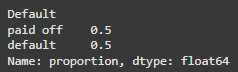

##Transformaciones y Preprocesamiento

In [ ]:
# Aplicamos transformaciones para las variables númericas
numeric_features = ['Importe', 'IngresoAnuales', 'RelacionIngresoDeuda', 'RelacionCuotaDeuda', 'PendienteEnTarjeta', 'UsoCreditoTarjeta', 'Cuentas', 'PuntuacionGeneral', 'AntiguedadLaboral']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Aplicamos transformaciones para las variables categóricas
categorical_features = ['Objetivo', 'esPropietario']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear el preprocesador utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Entrenamiento

En el contexto del enunciado, donde el objetivo es minimizar el número de créditos otorgados a posibles deudores a costa de perder algunos créditos a pagadores, el **Recall** sería la métrica de mayor peso.

La entidad bancaria tiene una preferencia explícita por evitar otorgar créditos a deudores, incluso si eso significa rechazar algunos solicitantes que podrían haber pagado sus créditos adecuadamente. Esto sugiere un enfoque en:

* **Minimizar los Falsos Negativos (FN):** No pasar por alto a los posibles deudores.
* **Maximizar el Recall:** Asegurar que la mayor cantidad posible de deudores reales sean capturados por el modelo.

### Preparar el conjunto de entrenamiento y prueba

In [ ]:
X = df.drop('Default_Encoded', axis=1)
y = df['Default_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Evaluamos los modelos con hiperparámetros por defecto

Haremos una primera evaluación de los diferentes modelos de clasificación vistos durante la cursada, con sus parametros por defecto.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = [
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression())
]

Configuraremos nuestro método de validación cruzada teniendo en cuenta lo visto al inicio del análisis, respecto al balanceo de nuestra variable objetivo.

Si la variable no estuviese balanceada podríamos utilizar esta configuración:


```
RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
```

In [ ]:
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
# Configuración del método de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42) # "Default" está correctamente balanceada (50%)

Ejecutamos el entrenamiento de cada modelo y guardamos el resultado para obtener un resumen al finalizar el procesamiento

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Lista para guardar los resultados
results = []
# Bucle para evaluar cada modelo
for name, model in models:
    # Crear el pipeline con el preprocesador y el modelo actual
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Aplicar validación cruzada y calcular el recall promedio
    recall_scores = cross_val_score(model_pipeline, X, y, cv=kf, scoring='recall')

    # Guardar los resultados
    results.append((name, recall_scores.mean(), recall_scores.std()))

# Convertir los resultados en un DataFrame para mejor manipulación
df_results = pd.DataFrame(results, columns=['Modelo', 'Recall promedio', 'Desviación estándar'])

Ordenamos los resultados basados en nuestra métrica objetivo (recall) para obtener una primera aproximación de que modelo sería el más óptimo

In [ ]:
# Ordenamos los modelos por la métrica que queremos
sort_by_metric = 'Recall promedio'
df_sorted = df_results.sort_values(by=sort_by_metric, ascending=False)

# Mostrar el ranking de modelos
print("Ranking de Modelos basado en :", sort_by_metric)
df_sorted

Ranking de Modelos basado en : Recall promedio


,Modelo,Recall promedio,Desviación estándar
1,Naive Bayes,0.651573,0.036979
3,Random Forest,0.635810,0.009325
4,Logistic Regression,0.620964,0.007287
0,KNN,0.574148,0.005086
2,Decision Tree,0.554327,0.008514


* **Conclusiones:** a partir de la primera evaluación de modelos tenemos un punto de partida para ahora sí evaluar los hiperparámetros que mejor se adapten al caso de estudio y logren mejorar la métrica de *recall* sin caer en el sobreajuste.

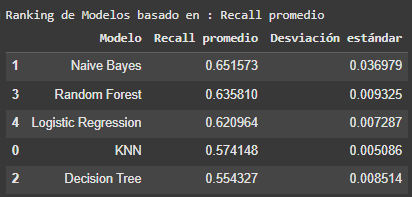

### Optimización de Modelos

Para cada modelo analizado en el paso anterior, aplicaremos las técnicas vistas durante la cursada para llegar a los hiperparametros óptimos y ver si llegamos a algún recall mejor que el de 0.6515 para Naive Bayes

####Naive Bayes

Utilizaremos `GridSearchCV()` para obtener el mejor `var_smotthing`

* Resultado:

```
Mejor var_smoothing: {'classifier__var_smoothing': 1e-09}
Mejor recall: 0.6838640040103965
```



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop('Default_Encoded', axis=1)
y = df['Default_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar el modelo Gaussian Naive Bayes
model_pipeline_nb2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])

# Configurar GridSearchCV para buscar el mejor var_smoothing
param_grid = {'classifier__var_smoothing': np.logspace(-9, 0, 100)}
grid_search = GridSearchCV(model_pipeline_nb2, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Mostrar el mejor valor de var_smoothing y el mejor recall
print("Mejor var_smoothing:", grid_search.best_params_)
print("Mejor recall:", grid_search.best_score_)

Mejor var_smoothing: {'classifier__var_smoothing': 1e-09}
Mejor recall: 0.6838640040103965


#### Random Forest

Analizaremos la curva de validación para obtener el `max_depth` óptimo

* Resultado:

```
Recall mejorado: 0.6646180860403863
RandomForestClassifier(max_depth=5)
```



In [ ]:
import numpy as np
from sklearn.model_selection import validation_curve

X = df.drop('Default_Encoded', axis=1)
y = df['Default_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model_pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(max_depth=15))
    ])

model_pipeline_rf.fit(X_train, y_train)
#generar rango de profundidad desde el 2 al 15
max_depths = np.arange(2,15)
# Calcular las curvas de validación
train_scores, valid_scores = validation_curve(model_pipeline_rf, X_train, y_train,
                                              param_name="classifier__max_depth",
                                              param_range=max_depths,
                                              scoring="recall",
                                              cv=5)

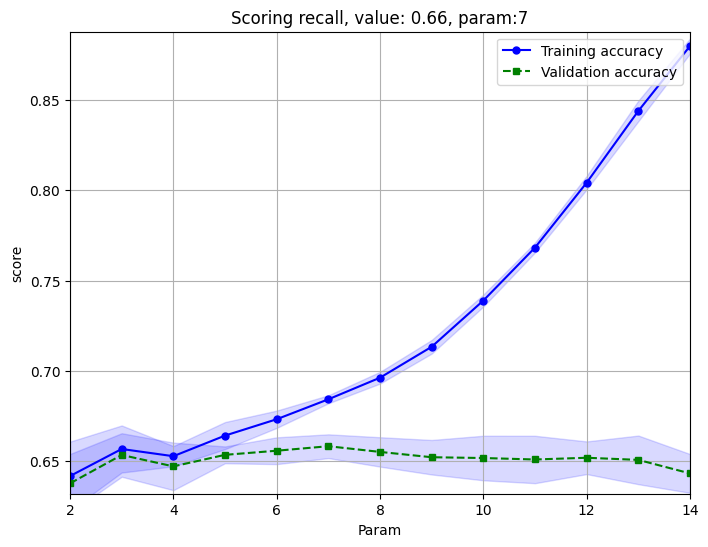

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import pandas as pd
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

def plt_validation_curve(hiperparams, train_scores, valid_scores, scoring='accuracy', ylims = None, figsize=(8, 6)):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, 1)
    valid_std = np.std(valid_scores, 1)

    maxmax = max(np.max(valid_mean), np.max(train_mean))
    minmin = min(np.min(valid_mean), np.min(train_mean))
    plt.figure(figsize=figsize)
    plt.plot(hiperparams, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    plt.fill_between(hiperparams, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(hiperparams, valid_mean, color='green', linestyle='--', marker='s', markersize=5,label='Validation accuracy')
    plt.fill_between(hiperparams,valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color='blue')

    plt.grid()
    plt.legend(loc='best')
    plt.xlim(min(hiperparams), max(hiperparams))
    plt.xlabel('Param')
    plt.ylabel('score')
    plt.legend(loc='upper right')
    plt.title("Scoring {}, value: {:.2}, param:{}".format(scoring, np.mean(valid_scores, 1).max(), hiperparams[np.mean(valid_scores, 1).argmax()]))
    #Atencion, es el maximo de todos los scores, no es representativo del score real

    if ylims is not None:
        plt.ylim(ylims)
    else:
        plt.ylim([minmin-(minmin*0.009), maxmax+(maxmax*0.009)])
    plt.show()

plt_validation_curve(max_depths, train_scores, valid_scores, scoring='recall')

In [ ]:
import numpy as np
from sklearn.model_selection import validation_curve

X = df.drop('Default_Encoded', axis=1)
y = df['Default_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model_pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(max_depth=5))
    ])

model_pipeline_rf.fit(X_train, y_train)
y_pred = model_pipeline_rf.predict(X_test)

# Calcular el recall
rec_rf = recall_score(y_test, y_pred)
print("Recall mejorado:", rec_rf)

Recall mejorado: 0.6646180860403863


#### Logistic Regression

Utilizaremos `GridSearchCV()` para obtener el mejor `C`

* Resultado:

```
Recall mejorado: 0.6251097453906936
LogisticRegression(C=0.1)
```



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Cargar y preparar los datos
X = df.drop('Default_Encoded', axis=1)
y = df['Default_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un pipeline con escalador y modelo
model_pipeline_rl = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ])

# Configurar GridSearch para optimizar hiperparámetros
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'] 
}
grid_search = GridSearchCV(model_pipeline_rl, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Evaluar el modelo
best_model = grid_search.best_estimator_

# Calcular y mostrar el recall
y_pred = best_model.predict(X_test)
print("Recall mejorado:", recall_score(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

Recall mejorado: 0.6251097453906936


#### KNN

Utilizaremos `GridSearchCV()` para obtener `n_neighbors` y `weights` óptimos

* Resultado:

```
Mejor recall alcanzado: 0.5899546500164311
KNeighborsClassifier(n_neighbors=29, weights='distance')
```


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score

# Preparar los datos
X = df.drop('Default_Encoded', axis=1)
y = df['Default_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Entrenar el modelo
model_pipeline_knn = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])


# Definir el espacio de parámetros para n_neighbors
parameters = {
    'classifier__n_neighbors': range(1, 31),
    'classifier__weights': ['uniform', 'distance'] 
}

# Configurar la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(model_pipeline_knn, parameters, cv=5, scoring='recall')

# Cargar los datos
X = df.drop('Default_Encoded', axis=1)
y = df['Default_Encoded']

# Ejecutar grid search
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_model
# Mostrar el mejor número de vecinos y el tipo de ponderación
print("Mejor número de vecinos:", grid_search.best_params_)
print("Mejor recall alcanzado:", grid_search.best_score_)

Mejor número de vecinos: {'classifier__n_neighbors': 29, 'classifier__weights': 'distance'}
Mejor recall alcanzado: 0.5899546500164311


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### Decision Tree

Utilizaremos `GridSearchCV()` para obtener `max_depth` `min_samples_leaf` y `min_samples_split` óptimos

* Resultado:

```
Recall mejorado: 0.6062257179261
DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=12)
```



In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
best_score = 0
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [4,5,6,7,8],
    'min_samples_split': [2, 4, 8, 10, 12, 14], 
    'min_samples_leaf': [2, 4, 6, 8, 10]
}

model_gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_gs)
])

model_pipeline.fit(X_train, y_train)
model_gs.best_estimator_

best_dtc_model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=12)

# Crear el pipeline con el preprocesador y el modelo actual
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_dtc_model)
])

# Aplicar validación cruzada y calcular el recall promedio
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
recall_scores = cross_val_score(model_pipeline, X, y, cv=kf, scoring='recall')

best_dtc_model_result = ('BEST DecisionTreeClassifier', recall_scores.mean(), recall_scores.std(), model_pipeline)
print(f"Modelo: {best_dtc_model_result[0]}, Recall promedio: {best_dtc_model_result[1]}, Desviación estándar: {best_dtc_model_result[2]}")

Modelo: BEST DecisionTreeClassifier, Recall promedio: 0.6062257179261, Desviación estándar: 0.02444668804588772


## Evaluamos los modelos con hiperparámetros Optimos

Repetimos la evaluación de modelos de clasificación, pero ahora sumando las configuraciones óptimas de hiperparametros para ver si existe algún cambio respecto del mejor modelo que hasta ahora viene siendo *Naive Bayes*...

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = [
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN (recall mejorado)', KNeighborsClassifier(n_neighbors=29, weights='distance')),
    ('Naive Bayes (recall mejorado)', GaussianNB(var_smoothing=1e-09)),
    ('Decision Tree (recall mejorado)', DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=12)),
    ('Random Forest (recall mejorado)', RandomForestClassifier(max_depth=5)),
    ('Logistic Regression (recall mejorado)', LogisticRegression(C=0.1))
]

# Configuración del método de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42) # "Default" está correctamente balanceada (50%)

results = []
for name, model in models:
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Aplicar validación cruzada y calcular el recall promedio
    recall_scores = cross_val_score(model_pipeline, X, y, cv=kf, scoring='recall')

    # Guardar los resultados
    results.append((name, recall_scores.mean(), recall_scores.std()))


df_results = pd.DataFrame(results, columns=['Modelo', 'Recall promedio', 'Desviación estándar'])

# Ordenamos los modelos por la métrica que queremos
sort_by_metric = 'Recall promedio'
df_sorted = df_results.sort_values(by=sort_by_metric, ascending=False)

# Mostrar el ranking de modelos
print("Ranking de Modelos basado en :", sort_by_metric)
df_sorted

Ranking de Modelos basado en : Recall promedio


,Modelo,Recall promedio,Desviación estándar
8,Random Forest (recall mejorado),0.651863,0.009789
1,Naive Bayes,0.651573,0.036979
6,Naive Bayes (recall mejorado),0.651573,0.036979
3,Random Forest,0.632172,0.006893
7,Decision Tree (recall mejorado),0.622556,0.016417
4,Logistic Regression,0.620964,0.007287
9,Logistic Regression (recall mejorado),0.620961,0.007930
5,KNN (recall mejorado),0.586444,0.011545
0,KNN,0.574148,0.005086
2,Decision Tree,0.555553,0.007438


# Conclusiones finales

A partir del analisis detallado en las secciones anteriores, concluimos en que el modelo que mejor se adapta para el caso de estudio es el de `RandomForestClassifer()` con la configuración de hiperparametros `max_depth=5`
```
RandomForestClassifier(max_depth=5)
```

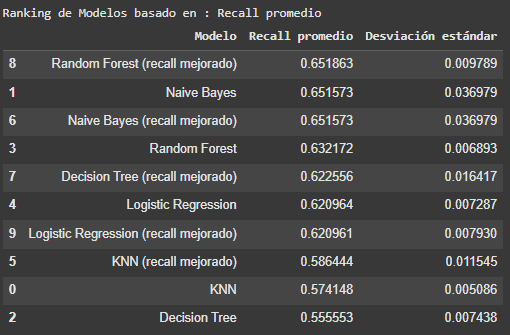

# Script Entregable Final
De esta manera, procederemos a construir el script final que sirva de entregable para la Evaluación docente.

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

EVALUACION = False
STUDENTDATAFILE = '/content/creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'

if EVALUACION==False:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/Facultad/3670 Ciencia de Datos/TP_FINAL/creditos_banco_alumnos.csv')
else:
    df = pd.read_csv(EVALDATAFILE)

# Convertir la columna 'Default' en valores binarios
df['Default_Encoded'] = df['Default'].map({'paid off': 0, 'default': 1})

# Aplicamos transformaciones para las variables númericas
numeric_features = ['Importe', 'IngresoAnuales', 'RelacionIngresoDeuda', 'RelacionCuotaDeuda', 'PendienteEnTarjeta', 'UsoCreditoTarjeta', 'Cuentas', 'PuntuacionGeneral', 'AntiguedadLaboral']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputación de Valores Faltantes: rellena los valores faltantes con la mediana de cada columna numérica.
    ('scaler', StandardScaler()) # El escalado estándar transforma cada característica para tener media 0 y desviación estándar 1.
])

# Aplicamos transformaciones para las variables categóricas
categorical_features = ['Objetivo', 'esPropietario']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Rellenar cualquier valor con el string 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Crea nuevas columnas para cada valor único, asignando un 1 o un 0 en caso que corresponda
])

# Crear el preprocesador utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Creamos el Pipeline
model_pipeline_panda5 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(max_depth=5))
    ])

# Entrenamos y evaluamos el Modelo
X_Eval = df.drop('Default_Encoded', axis=1)
y_Eval = df['Default_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X_Eval, y_Eval, test_size=0.3, random_state=42)

model_pipeline_panda5.fit(X_train, y_train)
y_pred = model_pipeline_panda5.predict(X_Eval)

print(classification_report(y_Eval, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63     17003
           1       0.64      0.66      0.65     17003

    accuracy                           0.64     34006
   macro avg       0.64      0.64      0.64     34006
weighted avg       0.64      0.64      0.64     34006



In [ ]:
model_pipeline_panda5

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Importe', 'IngresoAnuales',
                                                   'RelacionIngresoDeuda',
                                                   'RelacionCuotaDeuda',
                                                   'PendienteEnTarjeta',
                                                   'UsoCreditoTarjeta',
                                                   'Cuentas',
                                                   'PuntuacionGeneral',
                                                   'AntiguedadLaboral']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Objetivo',
                                                   'esPropietario'])])),
                ('classifier', RandomForestClassifier(max_depth=5))])

# Evaluacion final - Docente + Alumno

In [ ]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Lectura de datos

In [ ]:
df = pd.read_csv(STUDENTDATAFILE)

In [ ]:
EVALUACION = False
best_clf = model_pipeline_panda5 #None #Asignar aqui el mejor clasificador posible (previamente entrenado)
#best_clf = pl
#Leemos el dataset de evaluación, simulando producción
if EVALUACION==False:
    df = pd.read_csv(STUDENTDATAFILE)
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv(EVALDATAFILE)
#Dividimos en target y predictoras

X_Eval = df.drop("Default", axis=1)
y_Eval = df["Default"]

#Evaluación final

y_pred = best_clf.predict(X_Eval) # esto debe ser un pipeline completo
print(classification_report(y_Eval, y_pred))